# Vaccine Misinformation Classifier - OCR Pipeline

This notebook implements an OCR pipeline to extract text from images for vaccine misinformation classification.

#### Install Dependencies

In [43]:
# uncommenting this line will make the script executable
# !pip install pytesseract pillow requests

#### Import Libraries

In [44]:
import re
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter
from typing import Union
import io
import requests
import matplotlib.pyplot as plt

# Configure matplotlib to display images inline
%matplotlib inline

#### Image Preprocessing Function
##### Enhances image for better text recognition

In [45]:
def preprocess_image(image: Image.Image) -> Image.Image:
    """Apply preprocessing to improve OCR accuracy"""
    # Convert to grayscale
    image = image.convert('L')
    
    # Display the original and processed images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    
    # Enhance contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(2)
    
    # Resize if too small (minimum 300px on shortest side)
    width, height = image.size
    if min(width, height) < 300:
        scale = 300 / min(width, height)
        new_size = (int(width * scale), int(height * scale))
        image = image.resize(new_size, Image.LANCZOS)
    
    # Apply slight sharpening
    image = image.filter(ImageFilter.SHARPEN)
    
    # Display processed image
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.title('Processed Image')
    plt.show()
    
    return image

#### Text Cleaning Function
##### Removes noise from OCR output

In [46]:
def clean_extracted_text(text: str) -> str:
    """Clean the extracted OCR text"""
    print("Raw OCR Output:")
    print("--------------")
    print(text)
    print("\n")
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove emojis and special symbols
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub('', text)
    
    # Remove non-ASCII characters (keep only basic Latin)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # Replace multiple whitespace with single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Convert to lowercase
    text = text.lower()
    
    print("Cleaned Text:")
    print("------------")
    print(text)
    
    return text

#### Main OCR Extraction Function
##### Handles both local files and URLs

### **Input Types Supported:**
#### 1. Local file paths (JPEG, PNG, etc.)
#### 2. Web URLs (HTTP/HTTPS)
#### 3. Direct PIL Image objects

In [47]:
def extract_text_from_image(image_path: Union[str, Image.Image]) -> str:
    """
    Extract text from an image file or PIL Image object.
    
    Args:
        image_path: Path to image file or PIL.Image object
        
    Returns:
        Extracted and cleaned text string
    """
    # Load image if path is provided
    if isinstance(image_path, str):
        if image_path.startswith(('http://', 'https://')):
            # Download image from URL
            print(f"Downloading image from {image_path}")
            response = requests.get(image_path)
            image = Image.open(io.BytesIO(response.content))
        else:
            # Load from local file
            print(f"Loading image from {image_path}")
            image = Image.open(image_path)
    elif isinstance(image_path, Image.Image):
        image = image_path
    else:
        raise ValueError("Input must be image path (str) or PIL.Image object")
    
    # Display original image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')
    plt.show()
    
    # Preprocess image for better OCR results
    image = preprocess_image(image)
    
    # Use pytesseract to extract text
    try:
        text = pytesseract.image_to_string(image, lang='eng')
    except pytesseract.TesseractNotFoundError:
        raise RuntimeError(
            "Tesseract OCR is not installed or not in your PATH. "
            "Please install it from https://github.com/tesseract-ocr/tesseract"
        )
    
    # Clean the extracted text
    cleaned_text = clean_extracted_text(text)
    
    return cleaned_text

#### Example Usage

Loading image from examples/example_vaccine_post.jpg


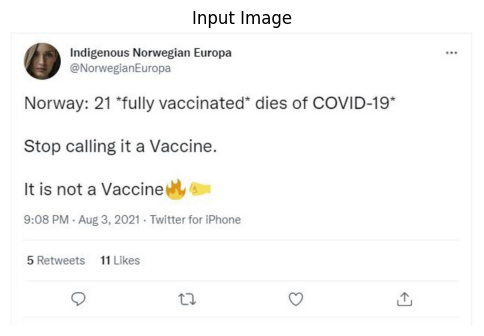

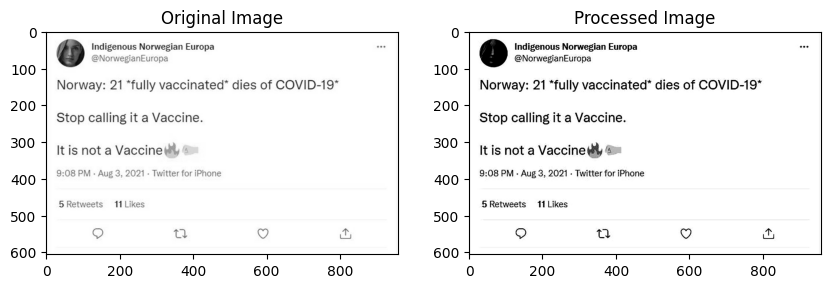

Raw OCR Output:
--------------
Indigenous Norwegian Europa
@NorwegianEuropa
Norway: 21 *fully vaccinated* dies of COVID-19*

Stop calling it a Vaccine.

It is not a Vaccine ey 4

9:08 PM - Aug 3, 2021 - Twitter for iPhone
5 Retweets 11 Likes

9) vd 9g

bP



Cleaned Text:
------------
indigenous norwegian europa @norwegianeuropa norway: 21 *fully vaccinated* dies of covid-19* stop calling it a vaccine. it is not a vaccine ey 4 9:08 pm - aug 3, 2021 - twitter for iphone 5 retweets 11 likes 9) vd 9g bp

Final Extracted Text:
--------------------
indigenous norwegian europa @norwegianeuropa norway: 21 *fully vaccinated* dies of covid-19* stop calling it a vaccine. it is not a vaccine ey 4 9:08 pm - aug 3, 2021 - twitter for iphone 5 retweets 11 likes 9) vd 9g bp


In [48]:
# Example 1: Local image
example_image_path = "examples/example_vaccine_post.jpg"  # Change this to your image path
try:
    extracted_text = extract_text_from_image(example_image_path)
    print("\nFinal Extracted Text:")
    print("--------------------")
    print(extracted_text)
except Exception as e:
    print(f"Error: {e}")

### NOTE: If you get the error "Tesseract OCR is not installed or not in your PATH",
#### uncomment and update the following line with the correct path to your Tesseract executable.
#### This is usually needed on Windows systems.

In [49]:
# import pytesseract

# For Windows — change this path if you installed it elsewhere
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"


#### This cell shows how to integrate with your vaccine misinformation classifier
#### Uncomment and modify as needed

In [50]:
"""
from transformers import pipeline

# Load your model
classifier = pipeline("text-classification", model="heishi99/vaccine-misinfo-bert")

def classify_vaccine_image(image_path):
    # Extract text
    text = extract_text_from_image(image_path)
    
    # Classify using your model
    result = classifier(text)
    
    return {
        "text": text,
        "classification": result
    }

# Example usage
result = classify_vaccine_image(example_image_path)
print(result)
"""

'\nfrom transformers import pipeline\n\n# Load your model\nclassifier = pipeline("text-classification", model="heishi99/vaccine-misinfo-bert")\n\ndef classify_vaccine_image(image_path):\n    # Extract text\n    text = extract_text_from_image(image_path)\n\n    # Classify using your model\n    result = classifier(text)\n\n    return {\n        "text": text,\n        "classification": result\n    }\n\n# Example usage\nresult = classify_vaccine_image(example_image_path)\nprint(result)\n'

# This cell shows how to integrate with your vaccine misinformation classifier

from transformers import pipeline

# Load your model
classifier = pipeline("text-classification", model="heishi99/vaccine-misinfo-bert")

def classify_vaccine_image(image_path):
    # Extract text
    text = extract_text_from_image(image_path)
    
    # Classify using your model
    result = classifier(text)
    
    return {
        "text": text,
        "classification": result
    }

# Example usage
result = classify_vaccine_image(example_image_path)
print(result)
